#Import Dependencies

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image,ImageEnhance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#directories for training and testing data
train="/content/drive/MyDrive/Brain Tumor/Training"
test="/content/drive/MyDrive/Brain Tumor/Testing"

In [6]:
class_names=sorted(os.listdir(train))
def encoder(labels):
  encoded=[class_names.index(label) for label in labels]

  return np.array(encoded)

In [7]:
#loading and shuffling of data (training)
train_data=[]
train_labels=[]
for label in os.listdir(train):
  for image in os.listdir(os.path.join(train,label)):
    train_data.append(os.path.join(train,label,image))
    train_labels.append(label)
train_data,train_labels=shuffle(train_data,train_labels)

train_labels=encoder(train_labels)

In [8]:
#loading and shuffling of data (testing)
test_data=[]
test_labels=[]
for label in os.listdir(test):
  for image in os.listdir(os.path.join(test,label)):
    test_data.append(os.path.join(test,label,image))
    test_labels.append(label)
test_data,test_labels=shuffle(test_data,test_labels)
test_labels=encoder(test_labels)

In [9]:
img=random.sample(range(len(train_data)),10)


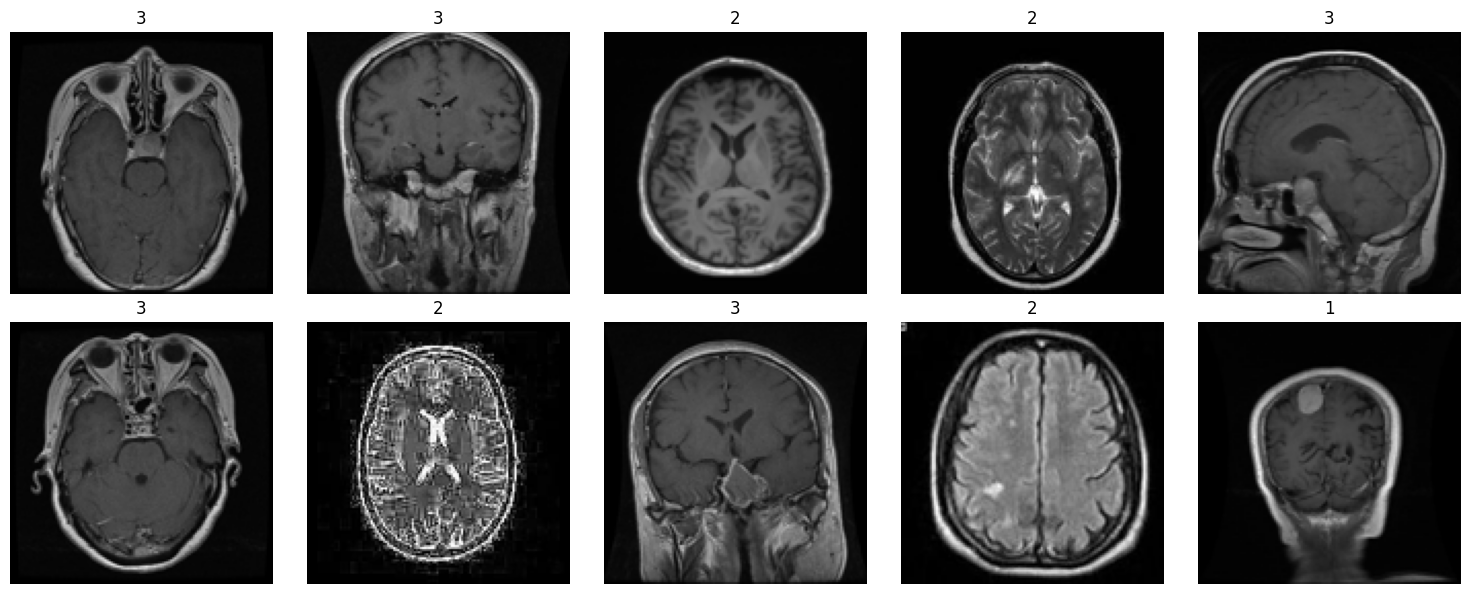

In [10]:
fig,axes=plt.subplots(2,5,figsize=(15,6))
axes=axes.ravel()
for i, index in enumerate(img):
  img_path=train_data[index]
  current_image = Image.open(img_path)
  current_image=current_image.resize((128,128))
  axes[i].imshow(current_image)
  axes[i].axis("off")
  axes[i].set_title(train_labels[index])
plt.tight_layout()
plt.show()

In [11]:
#Image Preprocessing
def augment(image):
  image=Image.fromarray(np.uint8(image))
  image=ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
  image=ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
  image=np.array(image)/255.0
  return image
def open_img(path):
  image=[]
  for path in path:
    img=load_img(path,target_size=(IMAGE_SIZE,IMAGE_SIZE))
    img=augment(img)
    image.append(img)
  return np.array(image)


def datagen(path,label,batch_size=12,epochs=1):
  for _ in range(epochs):
    for i in range(0, len(path),batch_size):
      batch_path=path[i:i+batch_size]
      batch_image=open_img(batch_path)
      batch_label=label[i:i+batch_size]
      yield batch_image,np.array(batch_label)

In [12]:
#Model Architecture
IMAGE_SIZE=128
base_model=VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights="imagenet")
for layer in base_model.layers:
  layer.trainable=False
base_model.layers[-2].trainable=True
base_model.layers[-3].trainable=True
base_model.layers[-4].trainable=True
model=Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(len(class_names), activation="softmax"))
model.compile(optimizer=Adam(learning_rate=0.0001),loss="sparse_categorical_crossentropy",metrics=["sparse_categorical_accuracy"])
batch_size=32
steps=int(len(train_data)/batch_size)
epochs=5
history=model.fit(
    datagen(train_data,train_labels,batch_size=batch_size,epochs=epochs),
    steps_per_epoch=steps,
    epochs=epochs
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 1304s 7s/step - loss: 0.7069 - sparse_categorical_accuracy: 0.7159
Epoch 2/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 1283s 7s/step - loss: 0.2512 - sparse_categorical_accuracy: 0.9066
Epoch 3/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 1293s 7s/step - loss: 0.1589 - sparse_categorical_accuracy: 0.9407
Epoch 4/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 1283s 7s/step - loss: 0.1088 - sparse_categorical_accuracy: 0.9584
Epoch 5/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 1323s 7s/step - loss: 0.1033 - sparse_categorical_accuracy: 0.9630


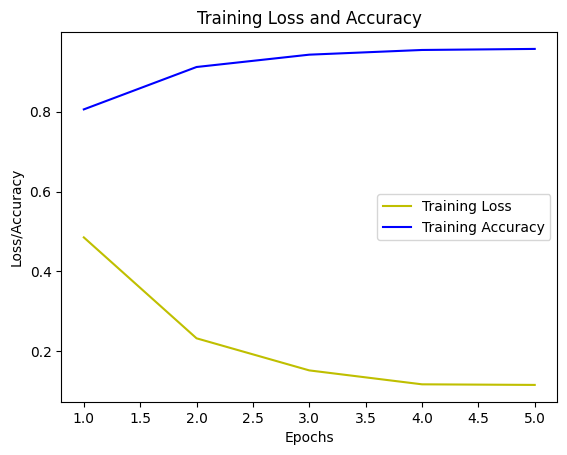

In [13]:
#loss and categoricalaccuracy plot
loss=history.history["loss"]
acc=history.history["sparse_categorical_accuracy"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,"y",label="Training Loss")
plt.plot(epochs,acc,"b",label="Training Accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


In [14]:
from sklearn.metrics import confusion_matrix,classification_report

In [17]:
y_pred=model.predict(open_img(test_data))
y_pred_classes=np.argmax(y_pred,axis=1)
print("Classification Report:\n",classification_report(test_labels,y_pred_classes,target_names=class_names))

42/42 ━━━━━━━━━━━━━━━━━━━━ 251s 6s/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.96      0.94      0.95       300
  meningioma       0.92      0.94      0.93       306
     notumor       1.00      0.98      0.99       405
   pituitary       0.97      0.99      0.98       310

    accuracy                           0.96      1321
   macro avg       0.96      0.96      0.96      1321
weighted avg       0.96      0.96      0.96      1321



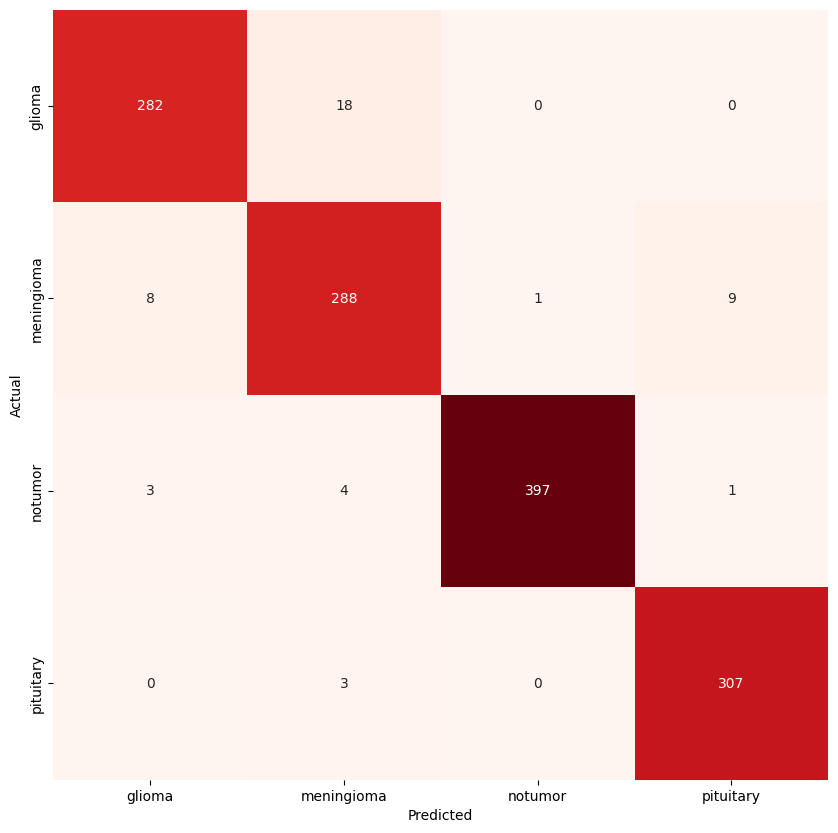

In [19]:
#cm
cm=confusion_matrix(test_labels,y_pred_classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,fmt="d",cmap="Reds",cbar=False,xticklabels=class_names,yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()